In [346]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# System Equations

### Linearizing $\ddot{x}$ and $\ddot{y}$

The dynamics of the drone in the x-direction can be described by the following equation:

$$
m \ddot{x} = \text{thrust} \cdot \sin(\theta)
$$

Assuming the drone is in a near-hover state, we can equate the thrust to the weight of the drone, i.e., $\text{thrust} = m \cdot g$. Substituting this into the equation, we get:

$$
\ddot{x} = g \cdot \sin(\theta)
$$

To simplify the model for small angles, we linearize $\sin(\theta)$ around 0. This leads to the following approximation:

$$
\ddot{x} \approx g \cdot \theta
$$

### Linearizing Thrust

The thrust in the context of vertical dynamics can be expressed as:

$$
\text{thrust} = m \cdot \frac{\ddot{z} + g}{\cos(\theta) \cdot \cos(\phi)}
$$

For small angles, we approximate $\cos(\theta)$ and $\cos(\phi)$ as 1. Hence, the equation simplifies to:

$$
\text{thrust} \approx m \cdot (\ddot{z} + g)
$$

From this approximation, we derive the vertical acceleration:

$$
\ddot{z} = \frac{\text{thrust} - \text{m} \cdot \text{g}}{m}
$$

These linearizations facilitate the analysis and control design for the drone in its near-hover state.

### System Matrices with States $x$, $y$, $z$, $\dot{x}$, $\dot{y}$, and $\dot{z}$

For the given system states, the matrices A, B, and C are defined as follows:

**Matrix A (State Transition Matrix):**

$$
A = \begin{bmatrix}
      0 & 0 & 0 & 1 & 0 & 0 \\
      0 & 0 & 0 & 0 & 1 & 0 \\
      0 & 0 & 0 & 0 & 0 & 1 \\
      0 & 0 & 0 & 0 & 0 & 0 \\
      0 & 0 & 0 & 0 & 0 & 0 \\
      0 & 0 & 0 & 0 & 0 & 0 \\
    \end{bmatrix}
$$

**Matrix B (Control Matrix):**

$$
B = \begin{bmatrix}
      0 & 0 & 0 \\
      0 & 0 & 0 \\
      0 & 0 & 0 \\
      g & 0 & 0 \\
      0 & g & 0 \\
      0 & 0 & \frac{1}{m} \\
    \end{bmatrix}
$$

**Matrix C (Output Matrix):**

$$
C = \begin{bmatrix}
      1 & 0 & 0 & 0 & 0 & 0 \\
      0 & 1 & 0 & 0 & 0 & 0 \\
      0 & 0 & 1 & 0 & 0 & 0 \\
    \end{bmatrix}
$$

These matrices represent the linearized model of the drone's motion, with $A$ describing the system dynamics, $B$ showing how control inputs affect the state, and $C$ representing the measured outputs.


# LQR and Kalman Filter Matrices

For the implementation of LQR (Linear Quadratic Regulator) and the Kalman Filter, specific matrices are used to define system dynamics and measurement models.

## LQR Matrices

The LQR matrices, `Q` and `R`, are defined as follows:

**Matrix Q (State-Cost Matrix):**

$$
Q = \begin{bmatrix}
      10 & 0 & 0 & 0 & 0 & 0 \\
      0 & 10 & 0 & 0 & 0 & 0 \\
      0 & 0 & 6 & 0 & 0 & 0 \\
      0 & 0 & 0 & 5 & 0 & 0 \\
      0 & 0 & 0 & 0 & 5 & 0 \\
      0 & 0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix}
$$

**Matrix R (Control-Cost Matrix):**

$$
R = \begin{bmatrix}
      5 & 0 & 0 \\
      0 & 5 & 0 \\
      0 & 0 & 60 \\
    \end{bmatrix}
$$

## Kalman Filter Matrices

For the Kalman Filter, the following matrices are used:

**Matrix Rw (Process Noise Covariance):**

Given parameters `r_xyz = 0.001`, `r_xyz_dot = 10`, the matrix `Rw` is formed as a block matrix:

$$
Rw = \begin{bmatrix}
      0.001^2 & 0 & 0 & 0 & 0 & 0 \\
      0 & 0.001^2 & 0 & 0 & 0 & 0 \\
      0 & 0 & 0.001^2 & 0 & 0 & 0 \\
      0 & 0 & 0 & 10^2 & 0 & 0 \\
      0 & 0 & 0 & 0 & 10^2 & 0 \\
      0 & 0 & 0 & 0 & 0 & 10^2 \\
    \end{bmatrix}
$$

**Matrix Rv (Measurement Noise Covariance):**

With `r_optitrack = 0.5`, the matrix `Rv` is:

$$
Rv = \begin{bmatrix}
      0.5^2 & 0 & 0 \\
      0 & 0.5^2 & 0 \\
      0 & 0 & 0.5^2 \\
    \end{bmatrix}
$$

**Initial Error Covariance:**

The initial error covariance matrix is given by:

$$
\text{Initial Error Covariance} = \begin{bmatrix}
                                    0.001 & 0 & 0 & 0 & 0 & 0 \\
                                    0 & 0.001 & 0 & 0 & 0 & 0 \\
                                    0 & 0 & 0.001 & 0 & 0 & 0 \\
                                    0 & 0 & 0 & 0.001 & 0 & 0 \\
                                    0 & 0 & 0 & 0 & 0.001 & 0 \\
                                    0 & 0 & 0 & 0 & 0 & 0.001 \\
                                  \end{bmatrix}
$$

These matrices are crucial for the effective implementation and tuning of LQR and Kalman Filter algorithms in control systems.


In [347]:
bag = rosbag.Bag('/home/miguel/catkin_ws/src/crazyflie/crazyflie_controller/src/data/LQG3.bag')

position_optitrack = []
desired_position = []
position_state_estimate = []
vel_state_estimate = []
vel_optitrack = []
desired_vel = []
control_input = []

for topic, msg, t in bag.read_messages(topics=['position_Optitrack', 'vel_Optitrack', 'position_estimate_topic', 'vel_estimate_topic', 'desired_position', 'desired_vel', 'control_input']):
    
    if topic == 'position_Optitrack':
        position_optitrack.append((msg.x, msg.y, msg.z))
        
    if topic == 'vel_Optitrack':
        vel_optitrack.append((msg.x, msg.y, msg.z))

    if topic == 'position_estimate_topic':
        position_state_estimate.append((msg.x, msg.y, msg.z))

    if topic == 'vel_estimate_topic':
        vel_state_estimate.append((msg.x, msg.y, msg.z))
        
    if topic == 'desired_position':
        desired_position.append((msg.x, msg.y, msg.z))
        
    if topic == 'desired_vel':
        desired_vel.append((msg.x, msg.y, msg.z))
    
    if topic == 'control_input':
        control_input.append((msg.x, msg.y, msg.z))
bag.close()

position_optitrack = np.array(position_optitrack)
vel_optitrack = np.array(vel_optitrack)
desired_position = np.array(desired_position)
desired_vel = np.array(desired_vel)
control_input = np.array(control_input)

In [348]:
time = []
initial_time = 0
Ts = 1/30

for i in range(len(position_optitrack)):
    time.append(initial_time)
    initial_time+=Ts

# X accel vs angle

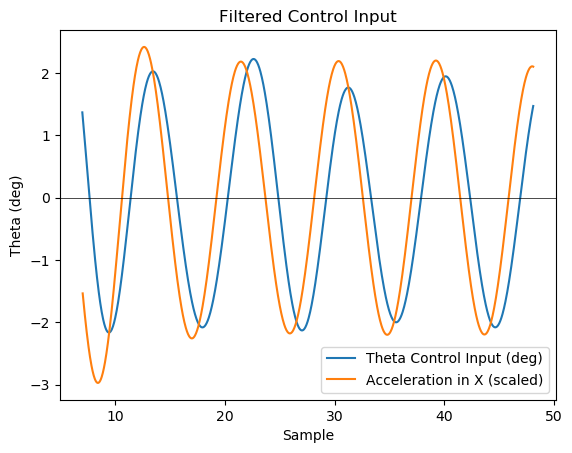

In [349]:
############### Finding the Acceleration ##################
# Filter parameters
N = 5  # Filter order
Wn = 0.01  # Cutoff frequency (as a fraction of the Nyquist frequency)
b, a = butter(N, Wn, 'low')

# Filter the velocity
vel_optitrack_ = np.array(vel_optitrack)[:, 0]
filtered_velocity = filtfilt(b, a, vel_optitrack_.squeeze())

# Numerical differentiation to find acceleration
dt = np.diff(time)  # Time intervals
acceleration = np.diff(filtered_velocity) / dt  # Numerical derivative


############## Filtering the Control Input ###############
control_input_ = np.array(control_input)[:, 0]
# Apply the filter
filtered_control_input = filtfilt(b, a, control_input_.squeeze())

# Convert to degrees
filtered_control_input_deg = np.rad2deg(filtered_control_input)

# Plotting
max_t = 18
min_t = 7
plt.plot(time[min_t*30:-max_t*30], filtered_control_input_deg[min_t*30:-max_t*30], label='Theta Control Input (deg)')
plt.plot(time[(1+min_t*30):-max_t*30], [x*5 for x in acceleration[min_t*30:-max_t*30]], label='Acceleration in X (scaled)')

plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('Sample')
plt.ylabel('Theta (deg)')
plt.title('Filtered Control Input')
plt.legend()
plt.show()

In [350]:
np.mean(filtered_control_input_deg[min_t*30:-max_t*30])

-0.13394178357893954

# Y accel vs angle

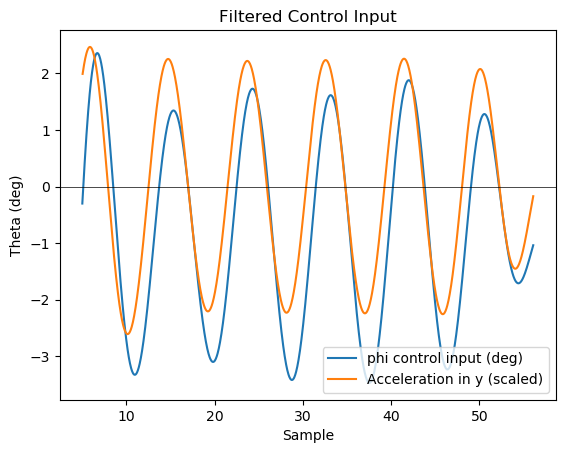

In [351]:
############### Finding the Acceleration ##################
# Filter parameters
N = 5  # Filter order
Wn = 0.01  # Cutoff frequency (as a fraction of the Nyquist frequency)
b, a = butter(N, Wn, 'low')

# Filter the velocity
vel_optitrack_ = np.array(vel_optitrack)[:, 1]
filtered_velocity = filtfilt(b, a, vel_optitrack_.squeeze())

# Numerical differentiation to find acceleration
dt = np.diff(time)  # Time intervals
acceleration = np.diff(filtered_velocity) / dt  # Numerical derivative


############## Filtering the Control Input ###############
control_input_ = np.array(control_input)[:, 1]
# Apply the filter
filtered_control_input = filtfilt(b, a, control_input_.squeeze())

# Convert to degrees
filtered_control_input_deg = np.rad2deg(filtered_control_input)

# Plotting
max_t = 10
min_t = 5

plt.plot(time[min_t*30:-max_t*30], filtered_control_input_deg[min_t*30:-max_t*30], label='phi control input (deg)')
plt.plot(time[(1+min_t*30):-max_t*30], [x*5 for x in acceleration[min_t*30:-max_t*30]], label='Acceleration in y (scaled)')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('Sample')
plt.ylabel('Theta (deg)')
plt.title('Filtered Control Input')
plt.legend()
plt.show()

In [352]:
np.mean(filtered_control_input_deg[min_t*30:-max_t*30])

-0.7230219326271005

# X

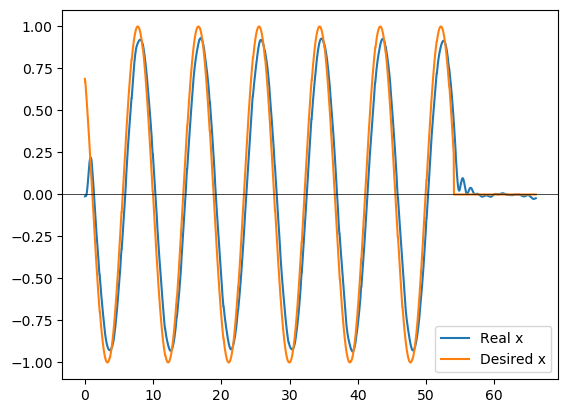

In [353]:
plt.plot(time, [x[0] for x in position_optitrack], label='Real x')
plt.plot(time, [x[0] for x in desired_position], label='Desired x')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.legend()
plt.show()

### X RMSE

In [354]:
x_square_error = (desired_position[:, 0] - position_optitrack[:, 0])**2
x_mse = np.sqrt(np.mean(x_square_error))
x_mse

0.16598158872922744

# Y

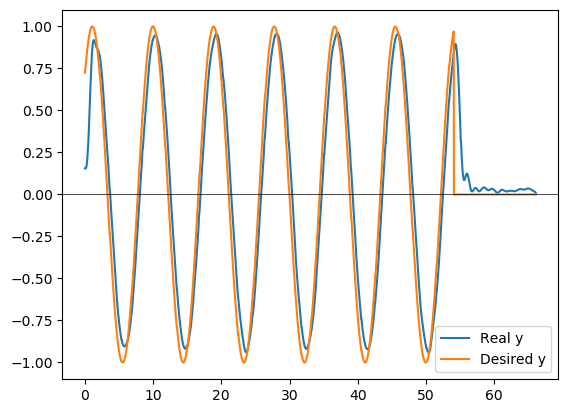

In [355]:
plt.plot(time, [x[1] for x in position_optitrack], label='Real y')
plt.plot(time, [x[1] for x in desired_position], label='Desired y')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.legend()
plt.show()

### Y RMSE

In [356]:
y_square_error = (desired_position[:, 1] - position_optitrack[:, 1])**2
y_rmse = np.sqrt(np.mean(y_square_error))
y_rmse

0.19694776799269528

# Z

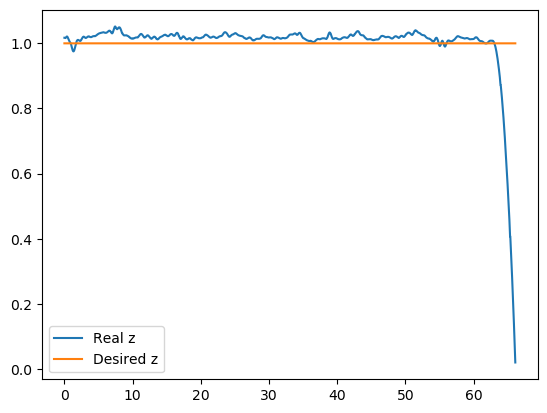

In [357]:
plt.plot(time, [x[2] for x in position_optitrack], label='Real z')
plt.plot(time, [x[2] for x in desired_position], label='Desired z')

plt.legend()
plt.show()

acc max used = 13.72

### Mean z position

In [358]:
np.mean(position_optitrack[:-5*30, 2])

1.0192597059608155

## Comparisons between estimated States vs Optitrack

### X

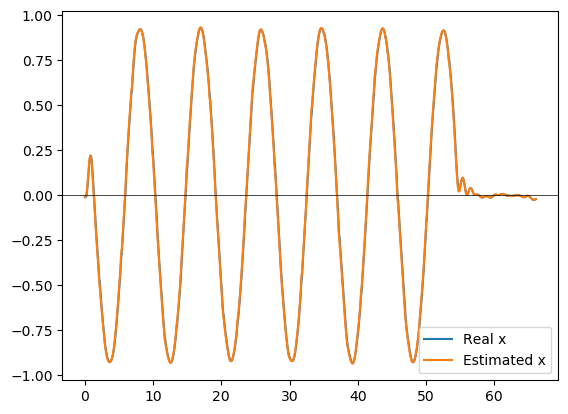

In [359]:
plt.plot(time, [x[0] for x in position_optitrack], label='Real x')
plt.plot(time, [x[0] for x in position_state_estimate], label='Estimated x')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.legend()
plt.show()

### Y

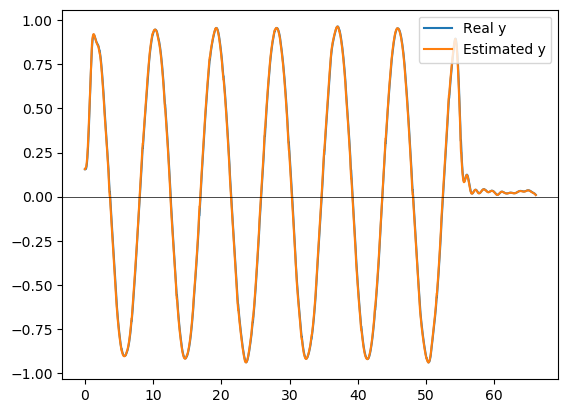

In [360]:
plt.plot(time, [x[1] for x in position_optitrack], label='Real y')
plt.plot(time, [x[1] for x in position_state_estimate], label='Estimated y')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.legend()
plt.show()

### Z

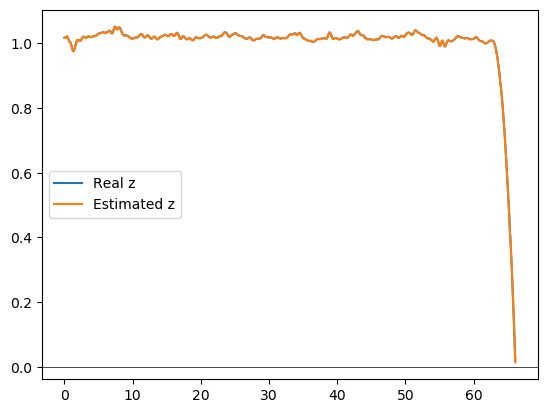

In [361]:
plt.plot(time, [x[2] for x in position_optitrack], label='Real z')
plt.plot(time, [x[2] for x in position_state_estimate], label='Estimated z')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.legend()
plt.show()

### VX

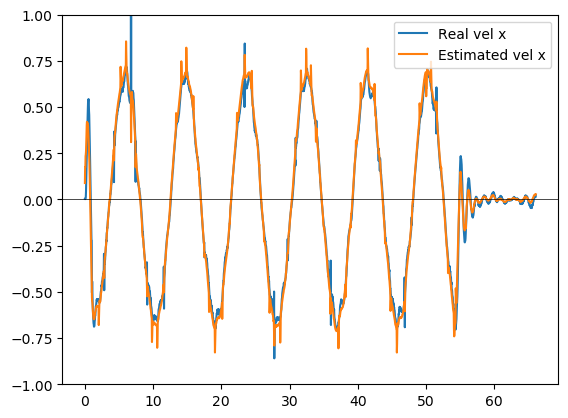

In [362]:
plt.plot(time, [x[0] for x in vel_optitrack], label='Real vel x')
plt.plot(time, [x[0] for x in vel_state_estimate], label='Estimated vel x')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.ylim(-1, 1)
plt.legend()
plt.show()

### VY

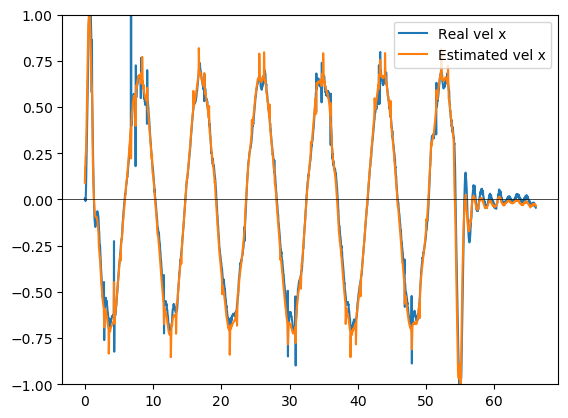

In [363]:
plt.plot(time, [x[1] for x in vel_optitrack], label='Real vel x')
plt.plot(time, [x[1] for x in vel_state_estimate], label='Estimated vel x')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.ylim(-1, 1)
plt.legend()
plt.show()

### VZ

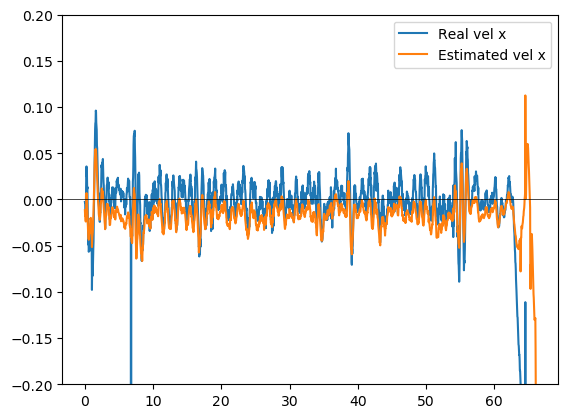

In [364]:
plt.plot(time, [x[2] for x in vel_optitrack], label='Real vel x')
plt.plot(time, [x[2] for x in vel_state_estimate], label='Estimated vel x')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.ylim(-0.2, 0.2)
plt.legend()
plt.show()

# Control Effort

## Theta

In [365]:
def control_effort(u):
    effort = 0
    for i in range(len(u) - 1):
        effort += u[i+1]-u[i]

    return effort

control_effort(np.array(control_input)[:, 0])

-0.2530597813377595

## phi

In [366]:
control_effort(np.array(control_input)[:, 1])

-0.2438055529635849

## Thrust

In [367]:
control_effort(np.array(control_input)[:, 2])

0.16397736220270093

# Conclusion

The LQG (Linear Quadratic Gaussian) controller, much like the LQR (Linear Quadratic Regulator), demonstrated excellent results. These improvements were largely attributed to the adjustments made to the weights of the Q and R matrices. With further experimentation, there's potential to identify the optimal matrices for even better performance.

A noteworthy aspect of this experiment is the incorporation of the Kalman filter, which functions partially as an Extended Kalman Filter due to its application to the Z axis. The results of the Kalman filter were outstanding, although additional testing is required, particularly using a sensor with higher noise levels, to fully assess its effectiveness.